In [1]:
import pprint
import json

import numpy as np
np.random.seed(17) # fix NumPy random number generator seed

import networkx as nx
import matplotlib.pyplot as plt


# add some relative paths so we can import sampling.py module.
import sys
sys.path.append("../")
sys.path.append("../src")
sys_path = sys.path

import sampling

In [2]:
# initialize graph:
dimensions=[3,3,2]
nodes = sampling.init_square_grid_nodes(dimensions=dimensions)
edges = sampling.init_square_grid_internal_edges(nodes=nodes)
edges = sampling.add_square_grid_periodic_boundary_edges(
    dimensions=dimensions,
    nodes=nodes,
    edges=edges
)
G = sampling.Graph(nodes=nodes, edges=edges)

n = len(G.nodes())

# no external field
B = np.zeros(n)
G.set_external_field(B)

# ferromagnetic edges:
J = {e:1.0 for e in G.edges()}
G.set_couplings(J)

print("There are",n,"nodes in the graph.")
N = 2**n
print("number of possible states: ", float(N))

There are 18 nodes in the graph.
number of possible states:  262144.0


In [3]:
# Set temperature:

# The critical temperature if J_ij == 1 (TODO: verify this...)
# T_c = 2/np.log(1+np.sqrt(2))
# print("Critical temperature T_c:",T_c)


T = 3.0 # set Temperature T
print("System temperature T:",T)

k_B = 1.0 # set Boltzmann constant
beta = 1/(k_B*T)

System temperature T: 3.0


sample: 0 / 100 ...
sample: 50 / 100 ...


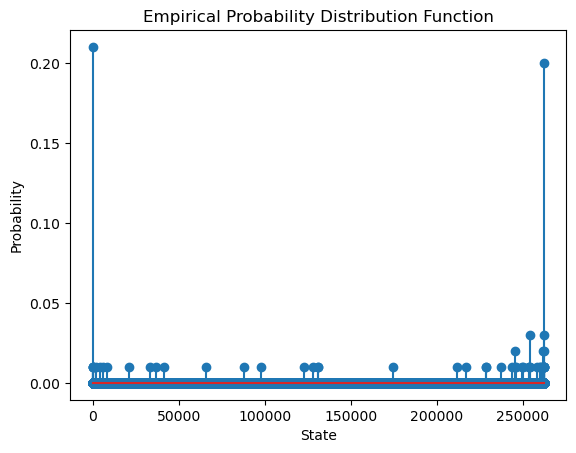

Note: if you used the same system parameters and lattice dimensions as in 02_brute_force_probability_distribution_calculation.ipynb, then this plot should look very similar.


In [5]:
# Monte Carlo Markov Chain (MCMC) with Metropolis Hastings (M-H) proposals.

num_samples_k = 100
num_steps = 500 # TODO: determine when the MCMC has mixed and stop!

# store samples as a dictionary with 
# counts of the number of times each state has appeared.
# samples = {} # necessary if N is very large.

empirical_pdf = np.zeros(N)

sample_energy_by_step = np.zeros((num_samples_k, num_steps))


for s in range(num_samples_k):

    # print status:
    if s % 50 == 0:
        print("sample:",s,"/",num_samples_k,"...")  

    # random starting spin_config:
    spin_config = sampling.generate_random_spin_config(n)
    G.set_spins(spin_config)

    i = 0
    for step in range(num_steps):
        energy, spin_config = G.mcmc_mh_step(
            beta=beta,
            target_spin=i
        )
        # run through nodes in typewriter order
        i += 1
        i = i % n

        sample_energy_by_step[s, step] = energy + 0.5*(np.random.random() - 0.5) # add random dither so plots look more interesting.
        
    
    # log final spin configuration
    final_state_index = sampling.convert_spin_config_to_state_index(G.get_spins())
    empirical_pdf[final_state_index] += 1

    
empirical_pdf *= (1/num_samples_k) #normalize

plt.stem(empirical_pdf)
plt.xlabel("State")
plt.ylabel("Probability")
plt.title("Empirical Probability Distribution Function")
plt.show()


print("Note: if you used the same system parameters and lattice dimensions as in 02_brute_force_probability_distribution_calculation.ipynb, then this plot should look very similar.")






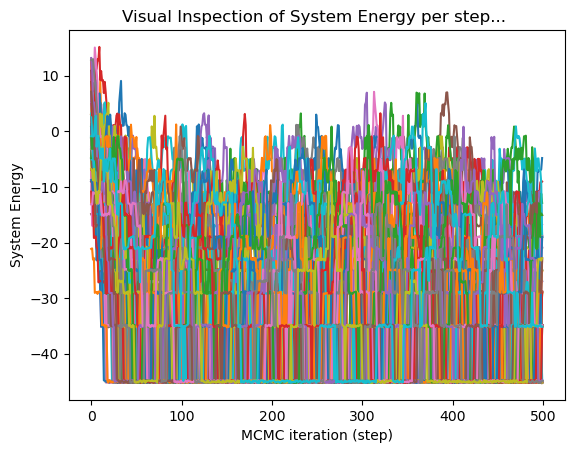

In [6]:
for s in range(num_samples_k):
    plt.plot(sample_energy_by_step[s,:])
plt.xlabel("MCMC iteration (step)")
plt.ylabel("System Energy")
plt.title("Visual Inspection of System Energy per step... ")
plt.show()